In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

In [2]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

In [4]:
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2
labels.unique()

tensor([0, 1, 2])

In [5]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

batchsize = 16
train_loader = DataLoader(train_data,batch_size = batchsize)
test_loader = DataLoader(test_data,batch_size = test_data.tensors[0].shape[0])

In [6]:
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()
        
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)
        
        self.dr = dropoutRate
        
    def forward(self,x):
            
            x = F.relu(self.input(x))
            x = F.dropout(x,p=self.dr,training=self.training)
            
            x = F.relu(self.hidden(x))
            x = F.dropout(x,p=self.dr,training=self.training)
            
            x = self.output(x)
            return x
            

In [7]:
tmpnet = theModelClass(.25)

tmpdata = torch.randn((10,4))
yHat = tmpnet(tmpdata)
yHat

tensor([[-0.3520, -0.2246, -0.1876],
        [-0.2915, -0.2485, -0.1005],
        [-0.3039, -0.2507, -0.0985],
        [-0.3213, -0.2737, -0.1652],
        [-0.4282, -0.2432, -0.1822],
        [-0.7480, -0.1934,  0.1051],
        [-0.3208, -0.0753, -0.2727],
        [-0.2663, -0.2715, -0.1155],
        [-0.0878, -0.3197, -0.0034],
        [-0.4236, -0.3613,  0.0021]], grad_fn=<AddmmBackward0>)

In [8]:
def createANewModel(dropoutrate):
    
    ANNiris = theModelClass(dropoutrate)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=0.005)
    
    return ANNiris,lossfun,optimizer

In [9]:
numepochs = 500

def trainTheModel():
    
    trainAcc = []
    testAcc = []
    
    for epochi in range(numepochs):
        
        ANNiris.train()
        
        batchAcc = []
        
        for X,y in train_loader:
            
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
            
        trainAcc.append( np.mean(batchAcc))
        ANNiris.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X),axis = 1 )
        testAcc.append(100*torch.mean((predlabels == y).float()).item())
    return trainAcc,testAcc

In [10]:
dropoutrate = .0
ANNiris,lossfun,optimizer = createANewModel(dropoutrate)
trainAcc,testAcc = trainTheModel()

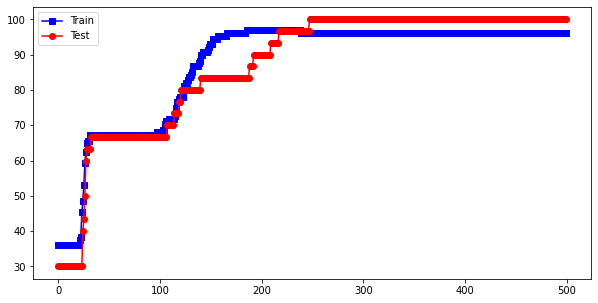

In [11]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.legend(['Train','Test'])
plt.show()